# Standard Feedforward Neural Network for Fertility Rate Prediction

This notebook implements a standard feedforward neural network (also called Multi-Layer Perceptron) to predict fertility rates.

## Architecture:
- Input layer: 29 features
- Hidden layers: Dense layers with ReLU activation
- Output layer: Single neuron (regression)
- Regularization: Dropout, L2 regularization
- Optimization: Adam optimizer

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn for metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("Libraries imported successfully!")

TensorFlow version: 2.20.0
GPU available: []
Libraries imported successfully!


## 1. Load Preprocessed Data

In [3]:
# Load preprocessed data
data_dir = '../data/processed'

X_train = np.load(f'{data_dir}/X_train.npy')
y_train = np.load(f'{data_dir}/y_train.npy')
X_val = np.load(f'{data_dir}/X_val.npy')
y_val = np.load(f'{data_dir}/y_val.npy')
X_test = np.load(f'{data_dir}/X_test.npy')
y_test = np.load(f'{data_dir}/y_test.npy')

# Load configuration
with open(f'{data_dir}/config.json', 'r') as f:
    config = json.load(f)

print("Data loaded successfully!")
print("="*80)
print(f"Training set:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set:       X={X_test.shape}, y={y_test.shape}")
print(f"\nNumber of features: {X_train.shape[1]}")
print(f"\nData split years:")
print(f"  Train: {config['train_years']}")
print(f"  Val:   {config['val_years']}")
print(f"  Test:  {config['test_years']}")

Data loaded successfully!
Training set:   X=(10384, 29), y=(10384,)
Validation set: X=(1519, 29), y=(1519,)
Test set:       X=(1302, 29), y=(1302,)

Number of features: 29

Data split years:
  Train: 1963-2010
  Val:   2011-2017
  Test:  2018-2023


In [4]:
# Load feature names for interpretation
with open(f'{data_dir}/feature_names.txt', 'r') as f:
    feature_names = f.read().strip().split('\n')

print(f"Feature names ({len(feature_names)} total):")
for i, name in enumerate(feature_names, 1):
    print(f"  {i:2d}. {name}")

Feature names (29 total):
   1. Maternal mortality ratio (per 100,000 live births)
   2. Urban population over total population
   3. Capital GDP in USD
   4. InfantMortality
   5. LifeExpectancy
   6. InfantMortality_lag3
   7. LifeExpectancy_lag3
   8. Urban population over total population_lag3
   9. Maternal mortality ratio (per 100,000 live births)_lag3
  10. Capital GDP in USD_lag3
  11. InfantMortality_pct_change
  12. LifeExpectancy_pct_change
  13. Urban population over total population_pct_change
  14. Maternal mortality ratio (per 100,000 live births)_pct_change
  15. Capital GDP in USD_pct_change
  16. HealthcareQuality_Index
  17. Urban_GDP_Interaction
  18. Era_1980-1999
  19. Era_2000-2019
  20. Era_2020+
  21. Development_Level_Low Income
  22. Development_Level_Lower Middle Income
  23. Development_Level_Upper Middle Income
  24. Decade_1970
  25. Decade_1980
  26. Decade_1990
  27. Decade_2000
  28. Decade_2010
  29. Decade_2020


## 2. Build the Neural Network Model

We'll create a feedforward neural network with:
- Multiple hidden layers
- Dropout for regularization
- Batch normalization for stable training

In [5]:
def build_model(input_dim, hidden_layers=[128, 64, 32], dropout_rate=0.3, l2_reg=0.01):
    """
    Build a feedforward neural network for regression.
    
    Parameters:
    - input_dim: Number of input features
    - hidden_layers: List of neurons in each hidden layer
    - dropout_rate: Dropout rate for regularization
    - l2_reg: L2 regularization strength
    
    Returns:
    - Compiled Keras model
    """
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(input_dim,)))
    
    # Hidden layers
    for i, units in enumerate(hidden_layers):
        model.add(layers.Dense(
            units, 
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg),
            name=f'dense_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'batch_norm_{i+1}'))
        model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))
    
    # Output layer (single neuron for regression)
    model.add(layers.Dense(1, name='output'))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

print("Model builder function defined!")

Model builder function defined!


In [6]:
# Build the model
model = build_model(
    input_dim=X_train.shape[1],
    hidden_layers=[128, 64, 32, 16],  # 4 hidden layers
    dropout_rate=0.3,
    l2_reg=0.01
)

# Display model architecture
print("Model Architecture:")
print("="*80)
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,681 (61.25 KB)

 Trainable params: 15,201 (59.38 KB)

 Non-trainable params: 480 (1.88 KB)

## 3. Set Up Training Callbacks

Callbacks help improve training:
- **EarlyStopping**: Stop if validation loss doesn't improve
- **ModelCheckpoint**: Save best model
- **ReduceLROnPlateau**: Reduce learning rate when stuck

In [8]:
# Create directory for saving models
import os
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath=f'{model_dir}/standard_nn_best.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

callback_list = [early_stopping, model_checkpoint, reduce_lr]

print("Callbacks configured:")
print("  - EarlyStopping (patience=20)")
print("  - ModelCheckpoint (save best model)")
print("  - ReduceLROnPlateau (reduce LR on plateau)")

Callbacks configured:
  - EarlyStopping (patience=20)
  - ModelCheckpoint (save best model)
  - ReduceLROnPlateau (reduce LR on plateau)


## 4. Train the Model

In [9]:
# Train the model
print("Starting training...")
print("="*80)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=callback_list,
    verbose=1
)

print("\n" + "="*80)
print("Training complete!")

Starting training...
Epoch 1/200
298/325 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 19.1424 - mae: 3.6177 - mse: 17.2229
Epoch 1: val_loss improved from None to 5.98425, saving model to ../models/standard_nn_best.keras
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 14.6073 - mae: 3.0669 - mse: 12.7082 - val_loss: 5.9843 - val_mae: 1.8672 - val_mse: 4.1204 - learning_rate: 0.0010
Epoch 2/200
302/325 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5450 - mae: 1.7245 - mse: 4.6998  
Epoch 2: val_loss improved from 5.98425 to 2.50063, saving model to ../models/standard_nn_best.keras
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6385 - mae: 1.5293 - mse: 3.8163 - val_loss: 2.5006 - val_mae: 0.6253 - val_mse: 0.7245 - learning_rate: 0.0010
Epoch 3/200
293/325 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 4.3902 - mae: 1.2559 - mse: 2.6379
Epoch 3: val_loss improved from 2.50063 to 2.35701, saving model to ../models/standard_nn_best.keras
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2647

## 5. Visualize Training History

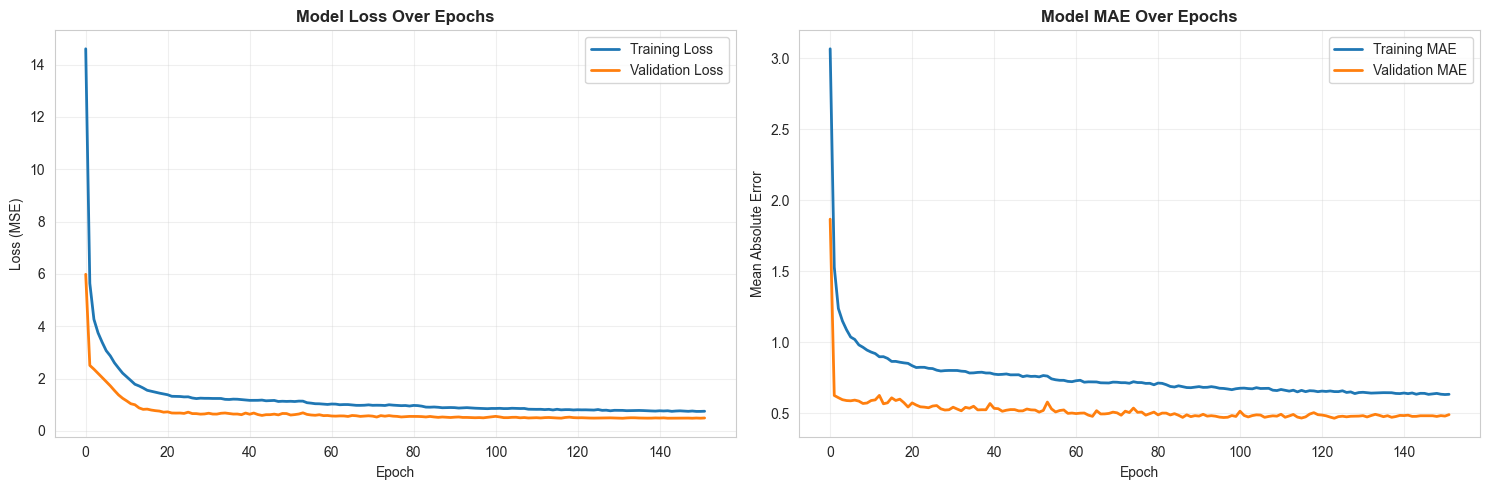


Best model at epoch 132 with validation loss: 0.4803


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss Over Epochs', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Model MAE Over Epochs', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print best epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = np.min(history.history['val_loss'])
print(f"\nBest model at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")

## 6. Evaluate on Test Set

In [ ]:
# Load best model
best_model = keras.models.load_model(f'{model_dir}/standard_nn_best.keras')
print("Best model loaded!")

# Make predictions on all sets
y_train_pred = best_model.predict(X_train, verbose=0).flatten()
y_val_pred = best_model.predict(X_val, verbose=0).flatten()
y_test_pred = best_model.predict(X_test, verbose=0).flatten()

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

print("="*80)
print("MODEL EVALUATION")
print("="*80)

train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val, y_val_pred, "Validatiosn")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

print("\n" + "="*80)

Best model loaded!
MODEL EVALUATION

Training Set Metrics:
  RMSE: 0.6273
  MAE:  0.4800
  R²:   0.9022

Validation Set Metrics:
  RMSE: 0.6349
  MAE:  0.4739
  R²:   0.7917

Test Set Metrics:
  RMSE: 0.9998
  MAE:  0.7708
  R²:   0.3556



## 7. Visualize Predictions

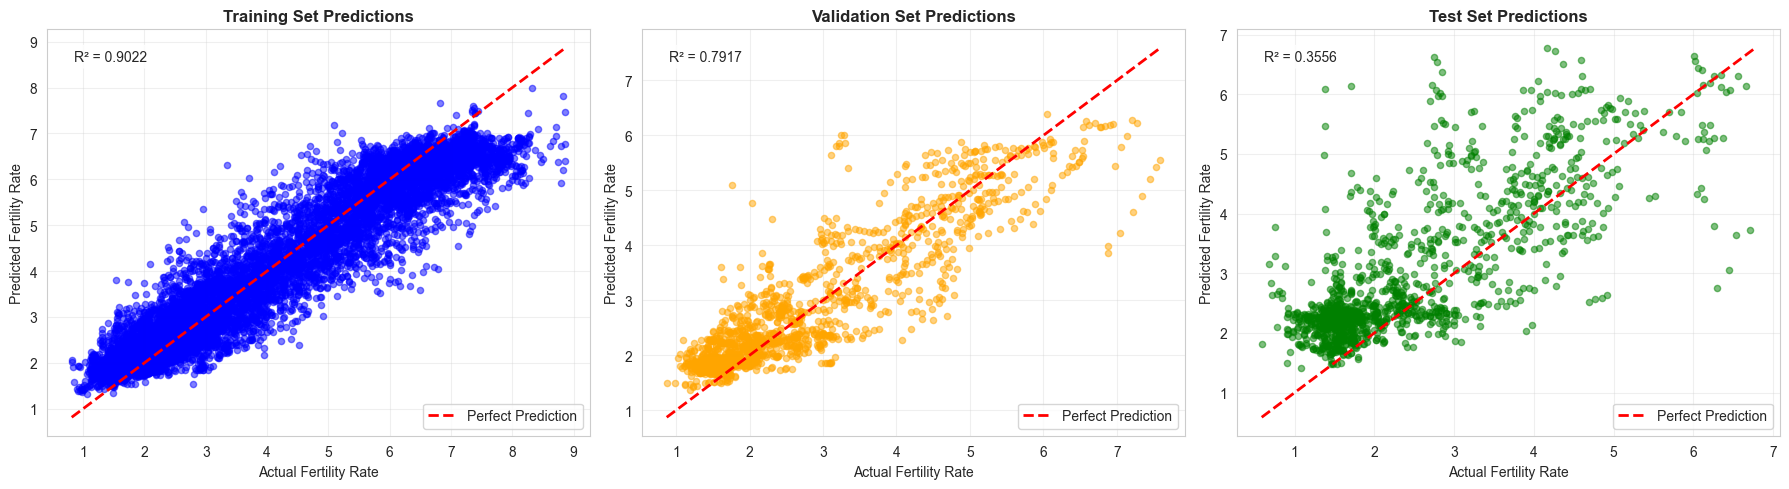

In [12]:
# Create prediction plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (y_train, y_train_pred, 'Training', 'blue'),
    (y_val, y_val_pred, 'Validation', 'orange'),
    (y_test, y_test_pred, 'Test', 'green')
]

for idx, (y_true, y_pred, name, color) in enumerate(datasets):
    # Scatter plot
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=20, color=color)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Labels and title
    axes[idx].set_xlabel('Actual Fertility Rate')
    axes[idx].set_ylabel('Predicted Fertility Rate')
    axes[idx].set_title(f'{name} Set Predictions', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    
    # Add R² to plot
    r2 = r2_score(y_true, y_pred)
    axes[idx].text(0.05, 0.95, f'R² = {r2:.4f}', 
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

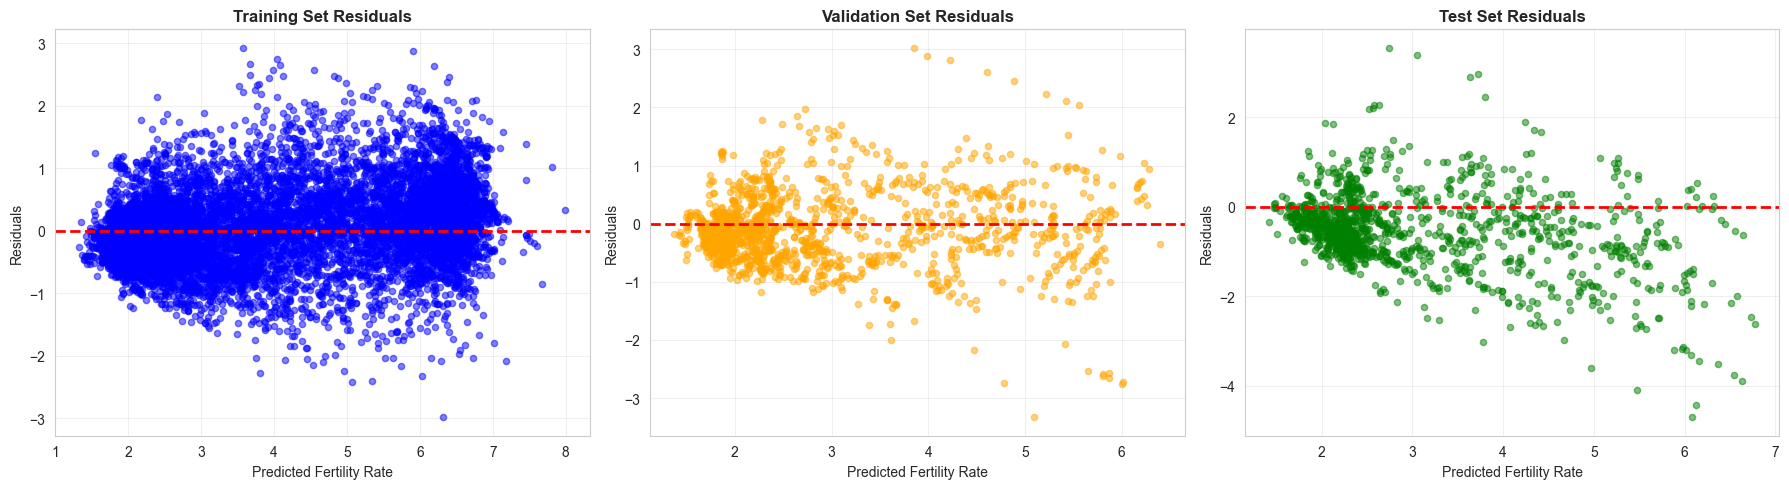

In [13]:
# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_true, y_pred, name, color) in enumerate(datasets):
    residuals = y_true - y_pred
    
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20, color=color)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Predicted Fertility Rate')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{name} Set Residuals', fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

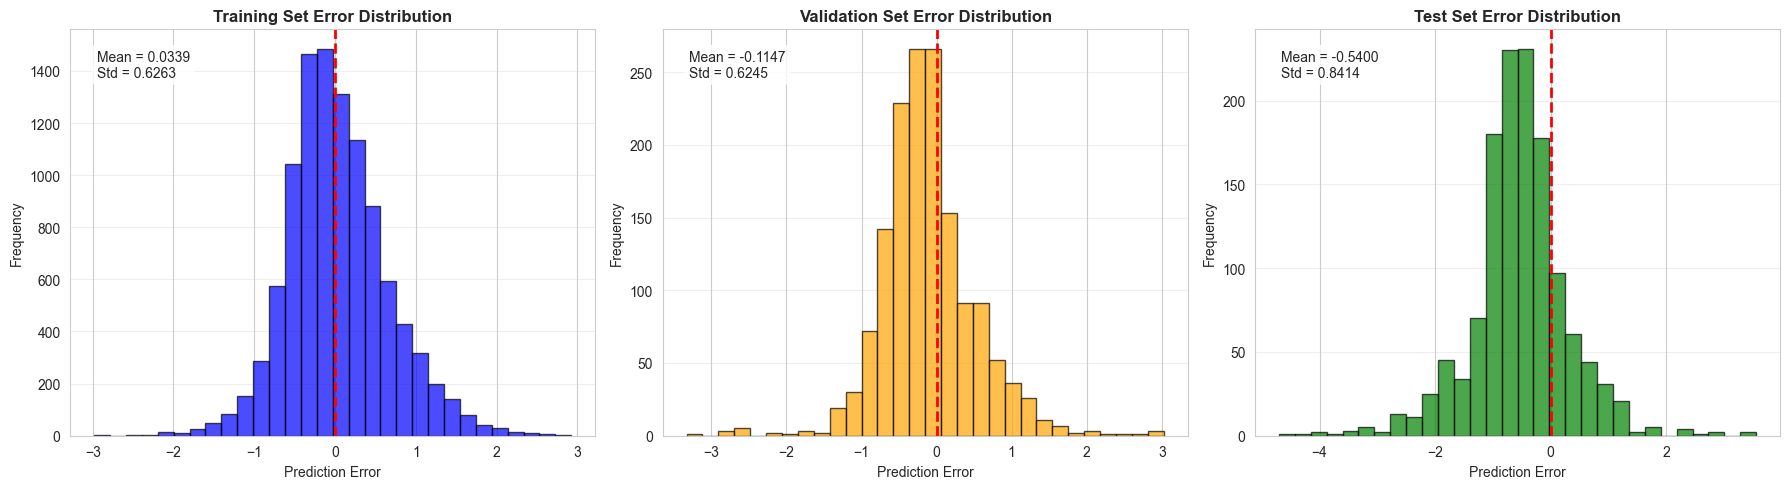

In [14]:
# Distribution of errors
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_true, y_pred, name, color) in enumerate(datasets):
    errors = y_true - y_pred
    
    axes[idx].hist(errors, bins=30, color=color, alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Prediction Error')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{name} Set Error Distribution', fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add mean and std to plot
    axes[idx].text(0.05, 0.95, f'Mean = {errors.mean():.4f}\nStd = {errors.std():.4f}', 
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 8. Save Results

In [15]:
# Save predictions
results = {
    'train': {'y_true': y_train, 'y_pred': y_train_pred, 'metrics': train_metrics},
    'val': {'y_true': y_val, 'y_pred': y_val_pred, 'metrics': val_metrics},
    'test': {'y_true': y_test, 'y_pred': y_test_pred, 'metrics': test_metrics}
}

# Save as pickle
with open(f'{model_dir}/standard_nn_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save metrics as JSON
metrics_summary = {
    'train': train_metrics,
    'val': val_metrics,
    'test': test_metrics,
    'model_config': {
        'hidden_layers': [128, 64, 32, 16],
        'dropout_rate': 0.3,
        'l2_reg': 0.01,
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'batch_size': 32,
        'total_epochs': len(history.history['loss']),
        'best_epoch': int(best_epoch)
    }
}

with open(f'{model_dir}/standard_nn_metrics.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

print("Results saved successfully!")
print(f"  - Model: {model_dir}/standard_nn_best.keras")
print(f"  - Results: {model_dir}/standard_nn_results.pkl")
print(f"  - Metrics: {model_dir}/standard_nn_metrics.json")

Results saved successfully!
  - Model: ../models/standard_nn_best.keras
  - Results: ../models/standard_nn_results.pkl
  - Metrics: ../models/standard_nn_metrics.json


## 9. Summary

In [16]:
print("="*80)
print("STANDARD NEURAL NETWORK - FINAL SUMMARY")
print("="*80)
print("\nModel Architecture:")
print(f"  - Input features: {X_train.shape[1]}")
print(f"  - Hidden layers: [128, 64, 32, 16]")
print(f"  - Total parameters: {model.count_params():,}")
print(f"  - Regularization: Dropout (0.3) + L2 (0.01)")

print("\nTraining:")
print(f"  - Total epochs: {len(history.history['loss'])}")
print(f"  - Best epoch: {best_epoch}")
print(f"  - Batch size: 32")
print(f"  - Optimizer: Adam (lr=0.001)")

print("\nFinal Performance:")
print("\n  Training Set:")
print(f"    RMSE: {train_metrics['rmse']:.4f}")
print(f"    MAE:  {train_metrics['mae']:.4f}")
print(f"    R²:   {train_metrics['r2']:.4f}")

print("\n  Validation Set:")
print(f"    RMSE: {val_metrics['rmse']:.4f}")
print(f"    MAE:  {val_metrics['mae']:.4f}")
print(f"    R²:   {val_metrics['r2']:.4f}")

print("\n  Test Set:")
print(f"    RMSE: {test_metrics['rmse']:.4f}")
print(f"    MAE:  {test_metrics['mae']:.4f}")
print(f"    R²:   {test_metrics['r2']:.4f}")

print("\n" + "="*80)
print("✓ Standard Neural Network training complete!")
print("="*80)

STANDARD NEURAL NETWORK - FINAL SUMMARY

Model Architecture:
  - Input features: 29
  - Hidden layers: [128, 64, 32, 16]
  - Total parameters: 15,681
  - Regularization: Dropout (0.3) + L2 (0.01)

Training:
  - Total epochs: 152
  - Best epoch: 132
  - Batch size: 32
  - Optimizer: Adam (lr=0.001)

Final Performance:

  Training Set:
    RMSE: 0.6273
    MAE:  0.4800
    R²:   0.9022

  Validation Set:
    RMSE: 0.6349
    MAE:  0.4739
    R²:   0.7917

  Test Set:
    RMSE: 0.9998
    MAE:  0.7708
    R²:   0.3556

✓ Standard Neural Network training complete!
